In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.13.0


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(seed=42)

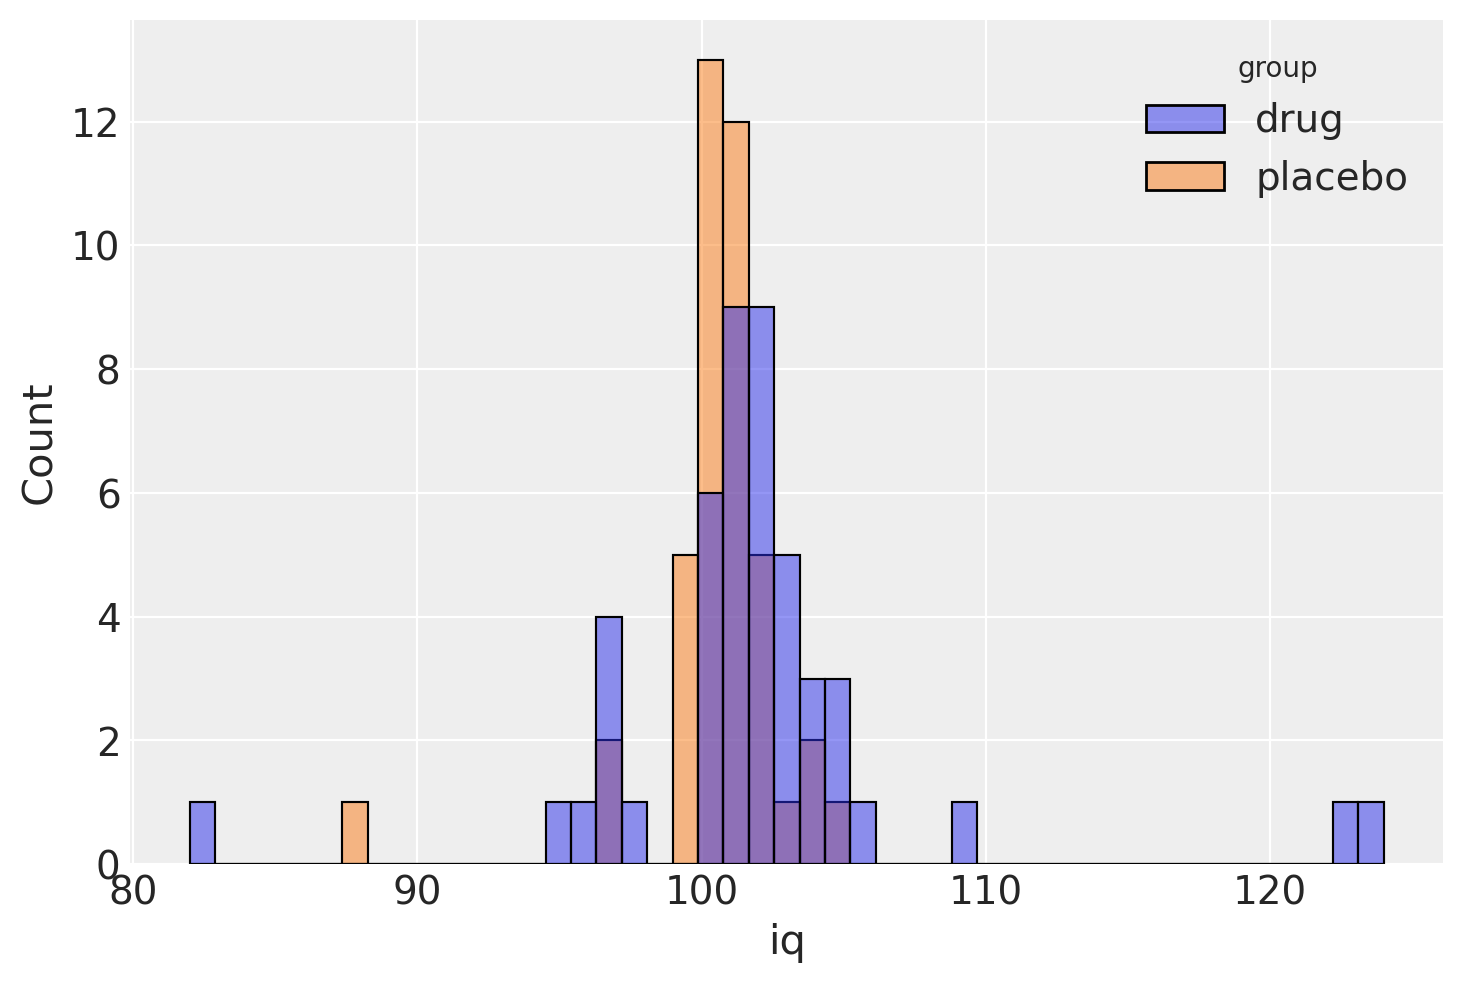

In [3]:
# fmt: off
iq_drug = np.array([
    101, 100, 102, 104, 102, 97, 105, 105, 98, 101, 100, 123, 105, 103, 
    100, 95, 102, 106, 109, 102, 82, 102, 100, 102, 102, 101, 102, 102,
    103, 103, 97, 97, 103, 101, 97, 104, 96, 103, 124, 101, 101, 100,
    101, 101, 104, 100, 101
])

iq_placebo = np.array([
    99, 101, 100, 101, 102, 100, 97, 101, 104, 101, 102, 102, 100, 105,
    88, 101, 100, 104, 100, 100, 100, 101, 102, 103, 97, 101, 101, 100,
    101, 99, 101, 100, 100, 101, 100, 99, 101, 100, 102, 99, 100, 99
])
# fmt: on

df1 = pd.DataFrame({"iq": iq_drug, "group": "drug"})
df2 = pd.DataFrame({"iq": iq_placebo, "group": "placebo"})
indv = pd.concat([df1, df2]).reset_index()

sns.histplot(data=indv, x="iq", hue="group");

In [4]:
mu_m = indv.iq.mean()
mu_s = indv.iq.std() * 2

with pm.Model() as model:
    group1_mean = pm.Normal("group1_mean", mu=mu_m, sigma=mu_s)
    group2_mean = pm.Normal("group2_mean", mu=mu_m, sigma=mu_s)

In [5]:
sigma_low = 10**-1
sigma_high = 10

with model:
    group1_std = pm.Uniform("group1_std", lower=sigma_low, upper=sigma_high)
    group2_std = pm.Uniform("group2_std", lower=sigma_low, upper=sigma_high)

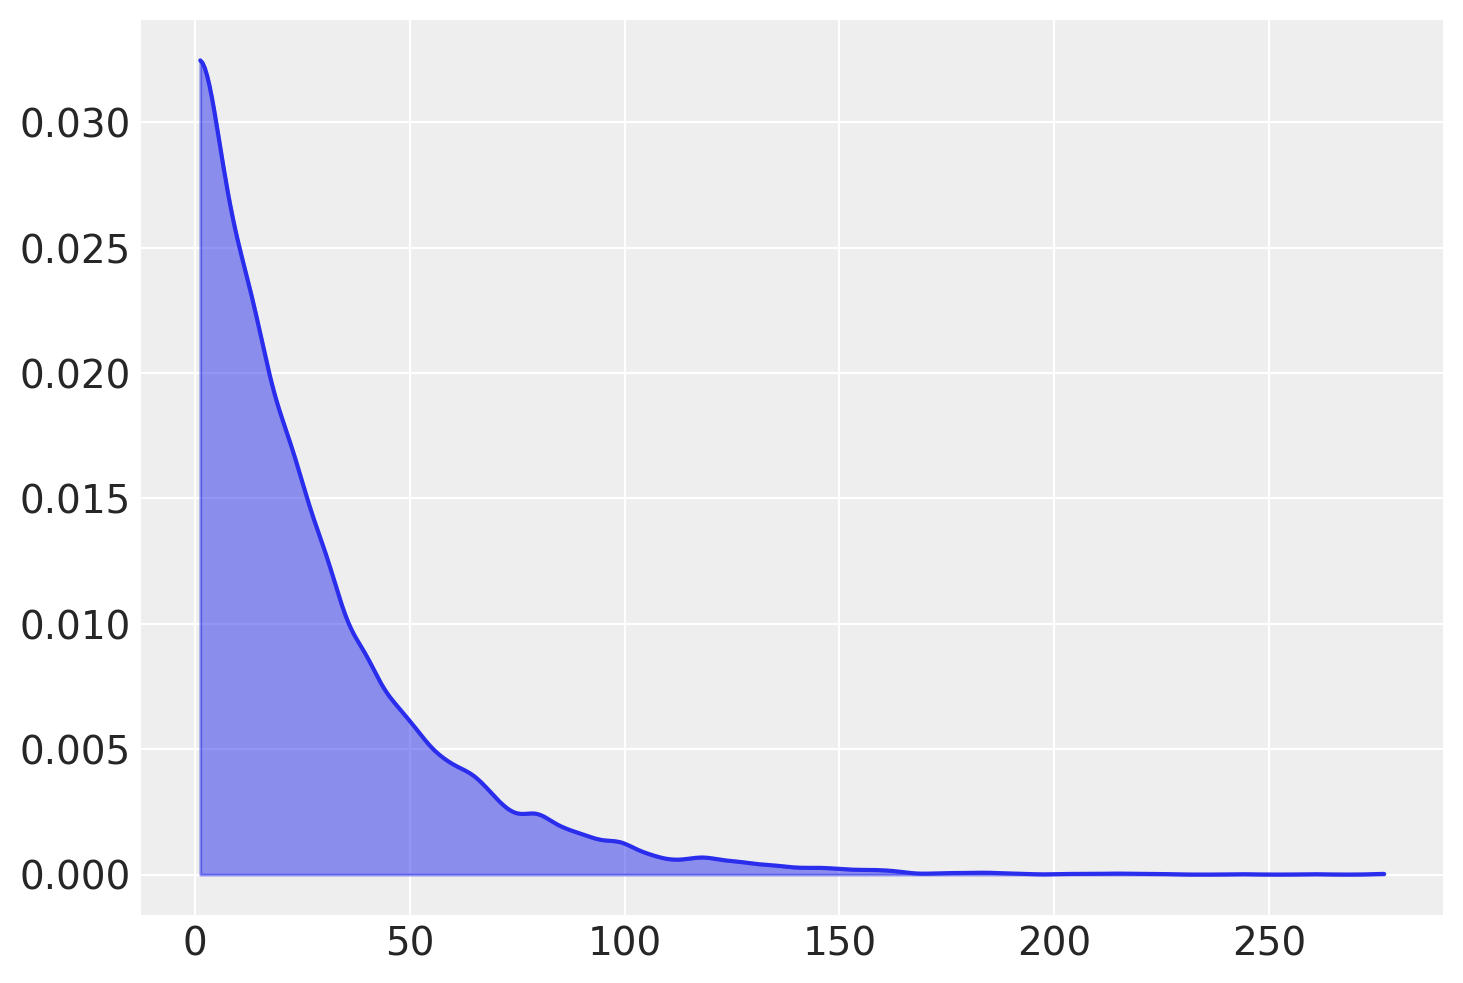

In [6]:
with model:
    nu_minus_one = pm.Exponential("nu_minus_one", 1 / 29.0)
    nu = pm.Deterministic("nu", nu_minus_one + 1)
    nu_log10 = pm.Deterministic("nu_log10", np.log10(nu))

az.plot_kde(rng.exponential(scale=29, size=10000) + 1, fill_kwargs={"alpha": 0.5});

In [7]:
with model:
    lambda_1 = group1_std**-2
    lambda_2 = group2_std**-2
    group1 = pm.StudentT("drug", nu=nu, mu=group1_mean, lam=lambda_1, observed=iq_drug)
    group2 = pm.StudentT("placebo", nu=nu, mu=group2_mean, lam=lambda_2, observed=iq_placebo)

In [8]:
with model:
    diff_of_means = pm.Deterministic("difference of means", group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic("difference of stds", group1_std - group2_std)
    effect_size = pm.Deterministic(
        "effect size", diff_of_means / np.sqrt((group1_std**2 + group2_std**2) / 2)
    )

In [ ]:

mu_m = indv.iq.mean()
mu_s = indv.iq.std() * 2
sigma_low = 10**-1
sigma_high = 10

with pm.Model() as model:
    group1_mean = pm.Normal("group1_mean", mu=mu_m, sigma=mu_s)
    group2_mean = pm.Normal("group2_mean", mu=mu_m, sigma=mu_s)

    group1_std = pm.Uniform("group1_std", lower=sigma_low, upper=sigma_high)
    group2_std = pm.Uniform("group2_std", lower=sigma_low, upper=sigma_high)

    nu_minus_one = pm.Exponential("nu_minus_one", 1 / 29.0)
    nu = pm.Deterministic("nu", nu_minus_one + 1)
    nu_log10 = pm.Deterministic("nu_log10", np.log10(nu))

    lambda_1 = group1_std**-2
    lambda_2 = group2_std**-2
    group1 = pm.StudentT("drug", nu=nu, mu=group1_mean, lam=lambda_1, observed=iq_drug)
    group2 = pm.StudentT("placebo", nu=nu, mu=group2_mean, lam=lambda_2, observed=iq_placebo)
    
    diff_of_means = pm.Deterministic("difference of means", group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic("difference of stds", group1_std - group2_std)
    effect_size = pm.Deterministic(
        "effect size", diff_of_means / np.sqrt((group1_std**2 + group2_std**2) / 2)
    )

In [9]:
with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group1_mean, group2_mean, group1_std, group2_std, nu_minus_one]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


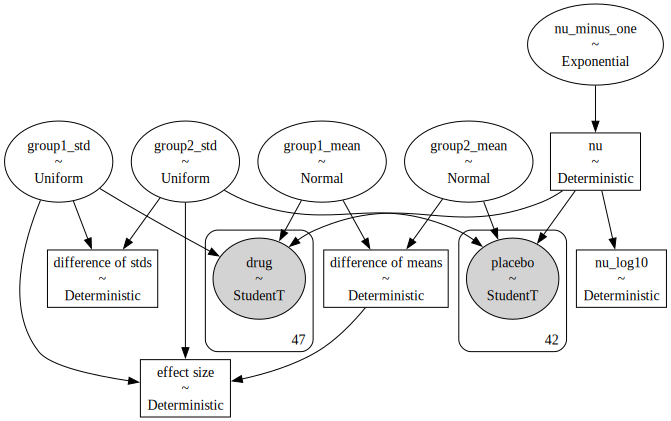

In [15]:
pm.model_to_graphviz(model)

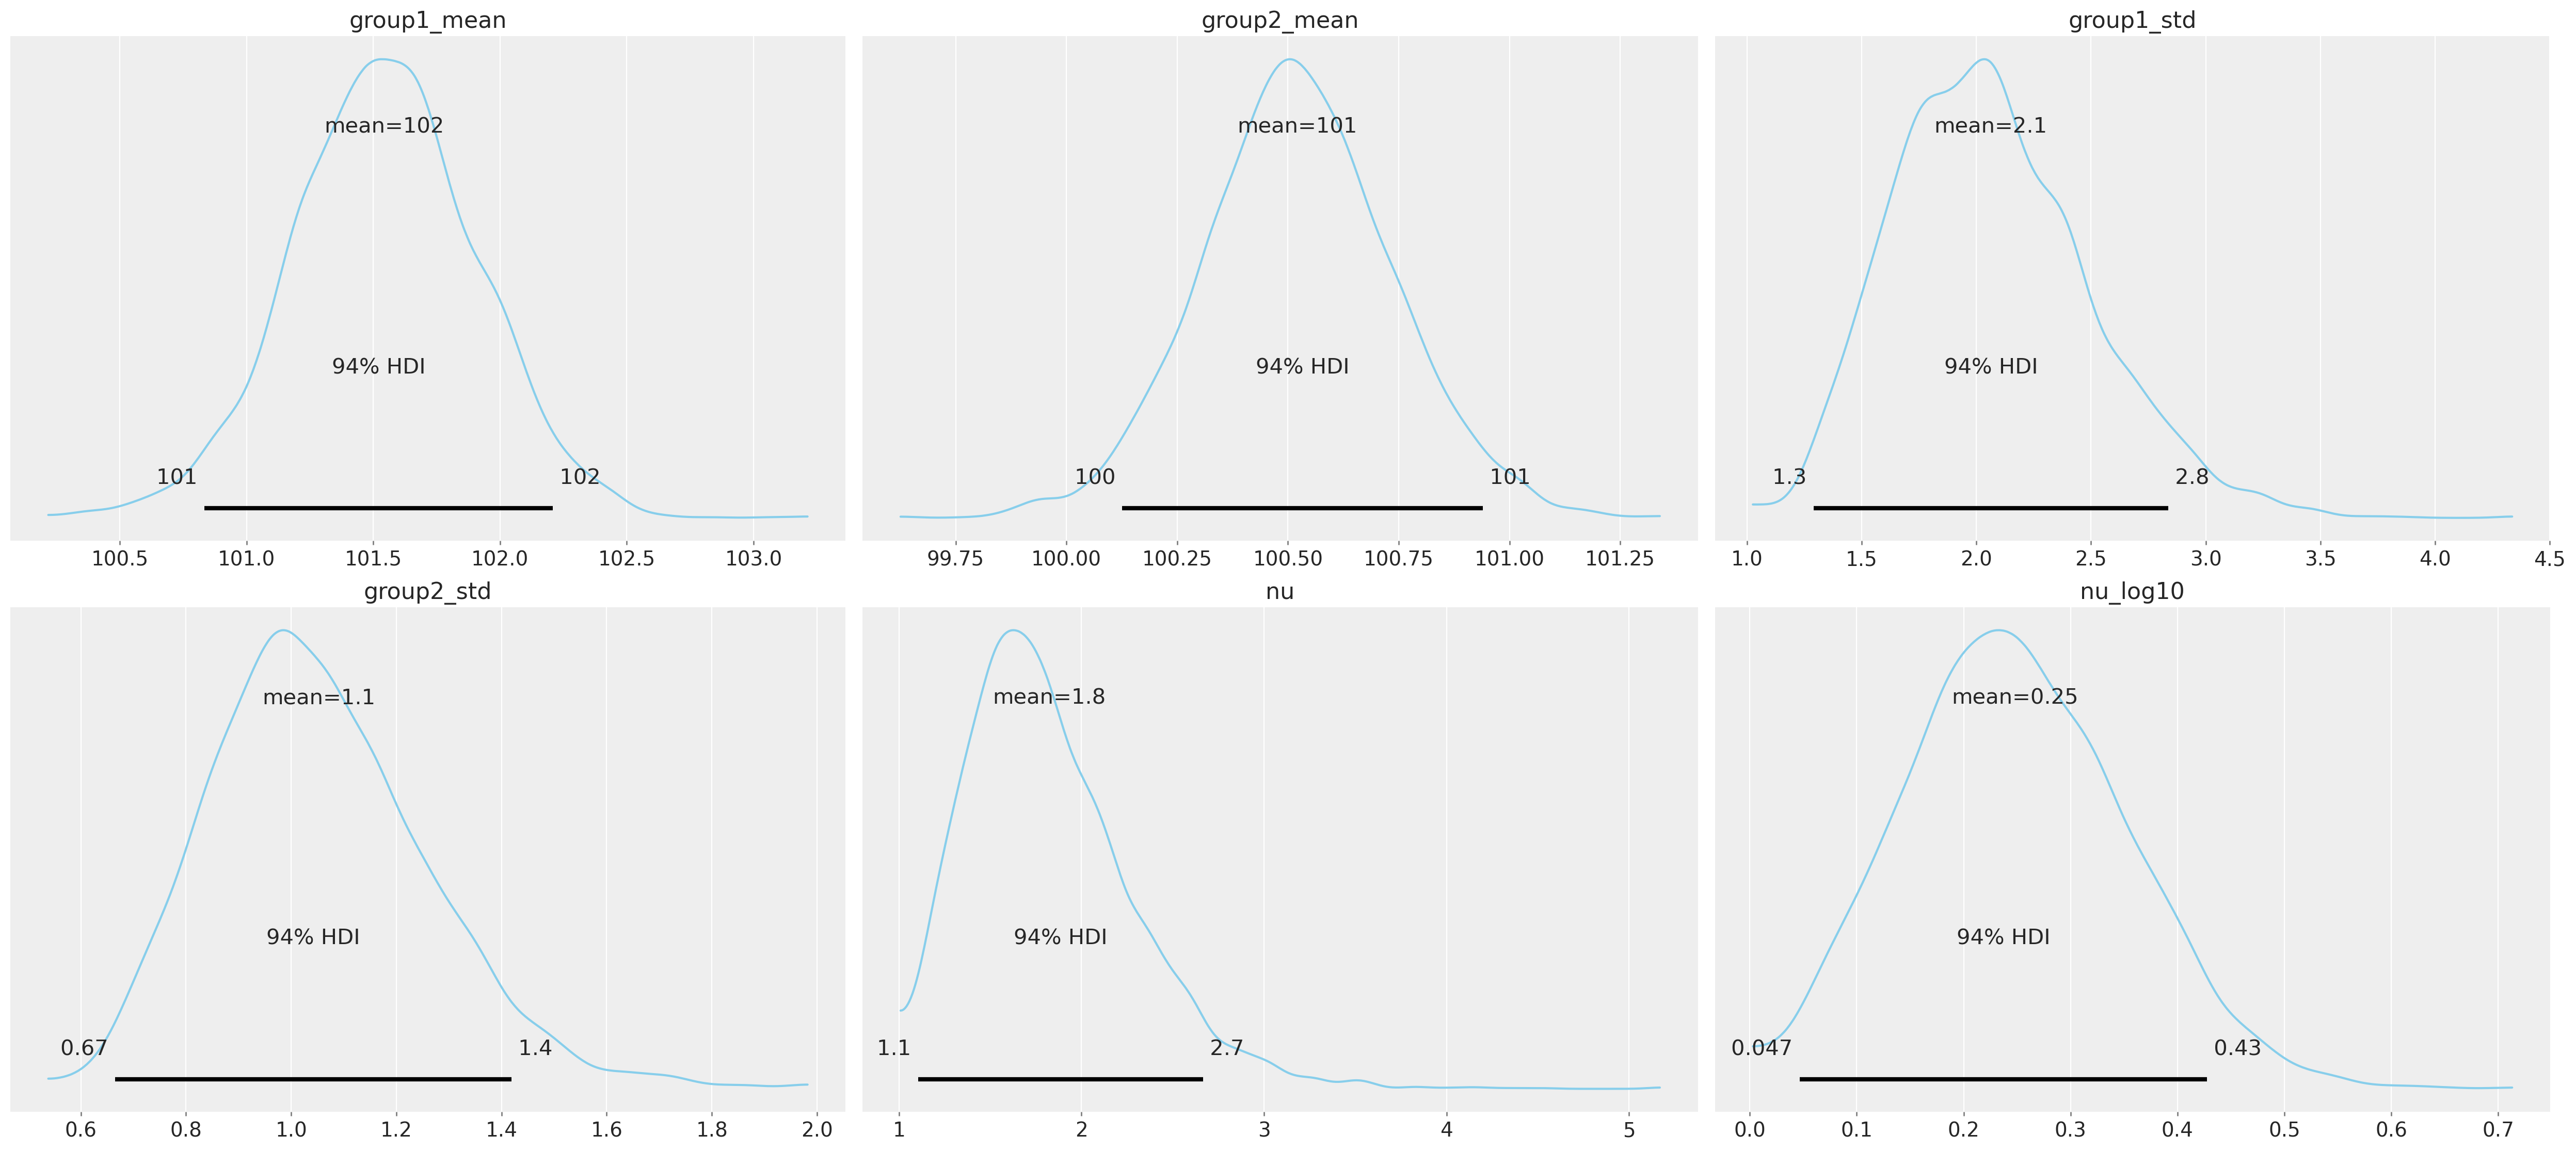

In [10]:
az.plot_posterior(
    idata,
    var_names=["group1_mean", "group2_mean", "group1_std", "group2_std", "nu", "nu_log10"],
    color="#87ceeb",
);

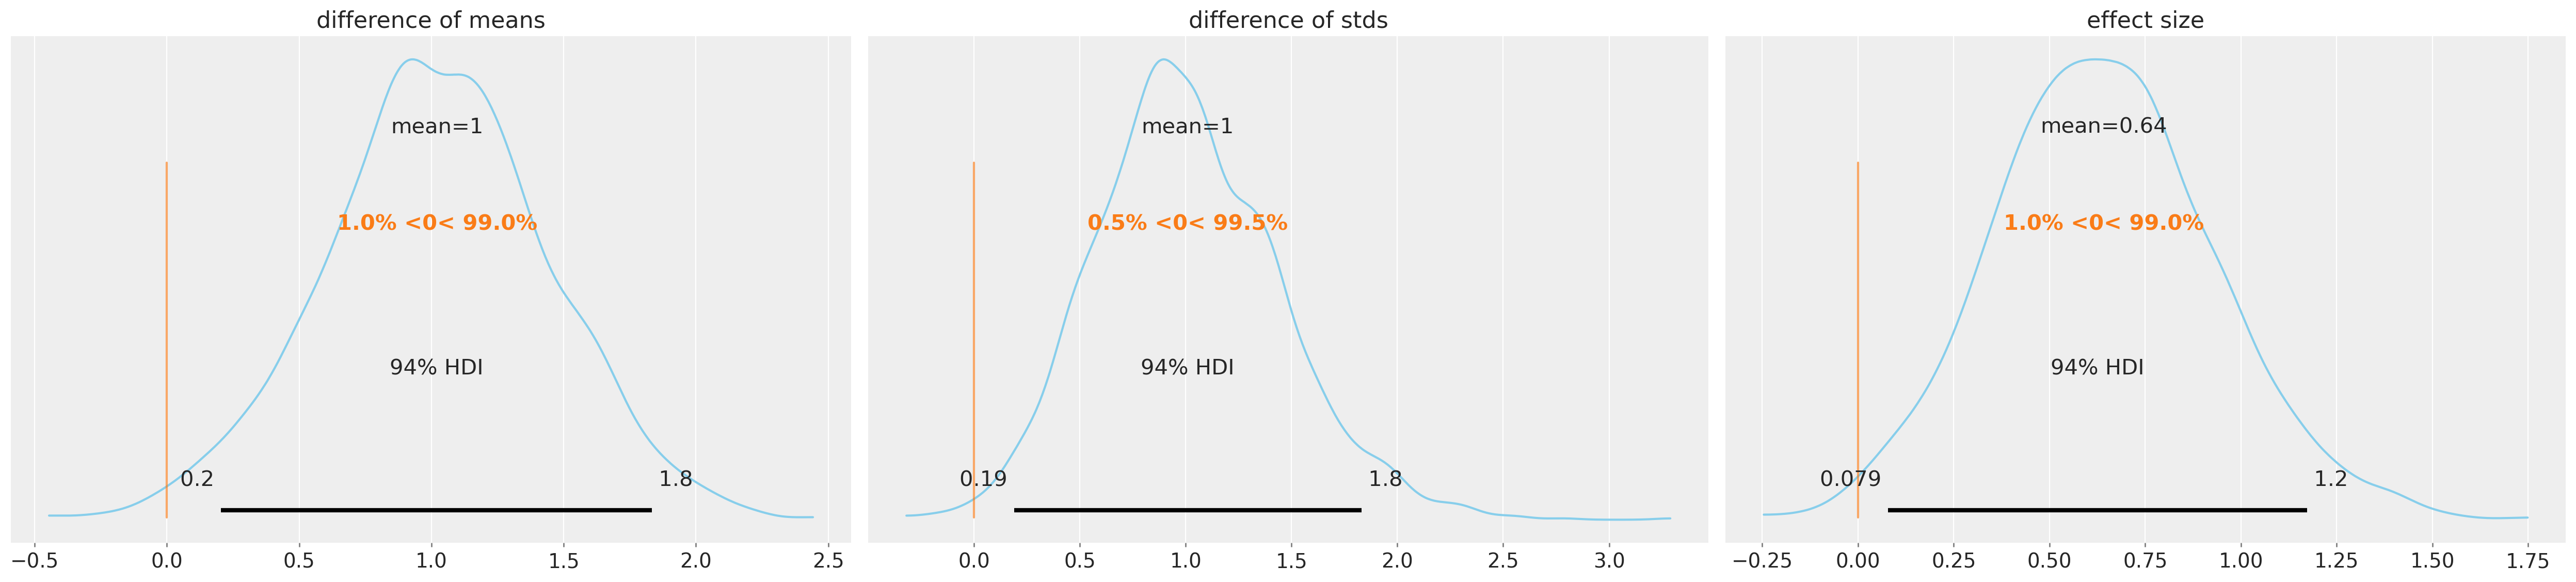

In [11]:
az.plot_posterior(
    idata,
    var_names=["difference of means", "difference of stds", "effect size"],
    ref_val=0,
    color="#87ceeb",
);

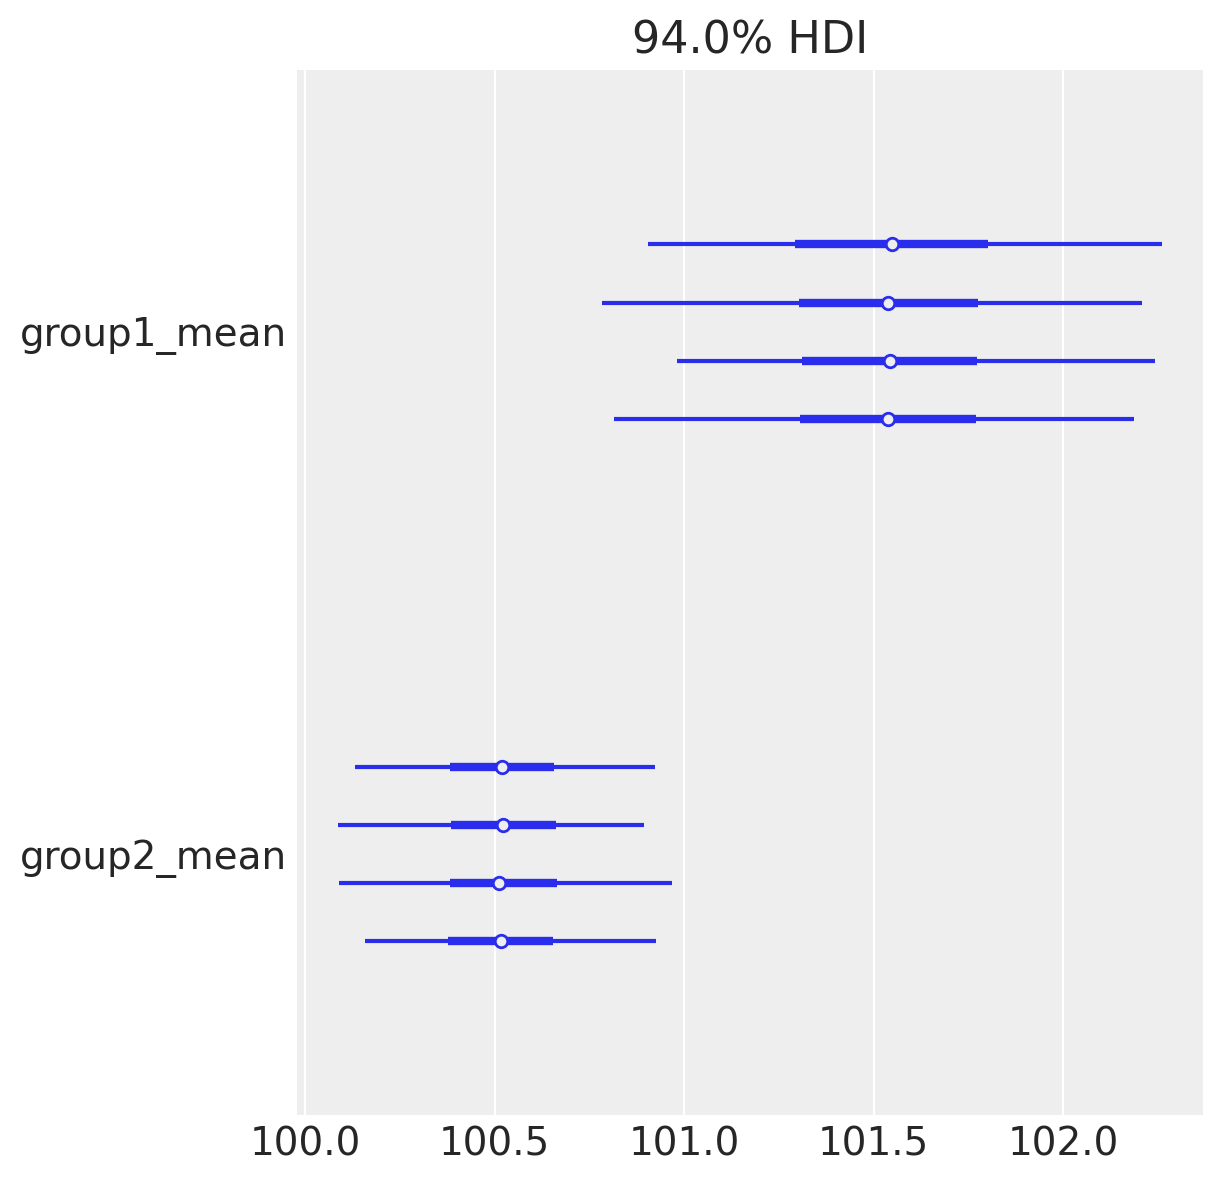

In [12]:
az.plot_forest(idata, var_names=["group1_mean", "group2_mean"]);

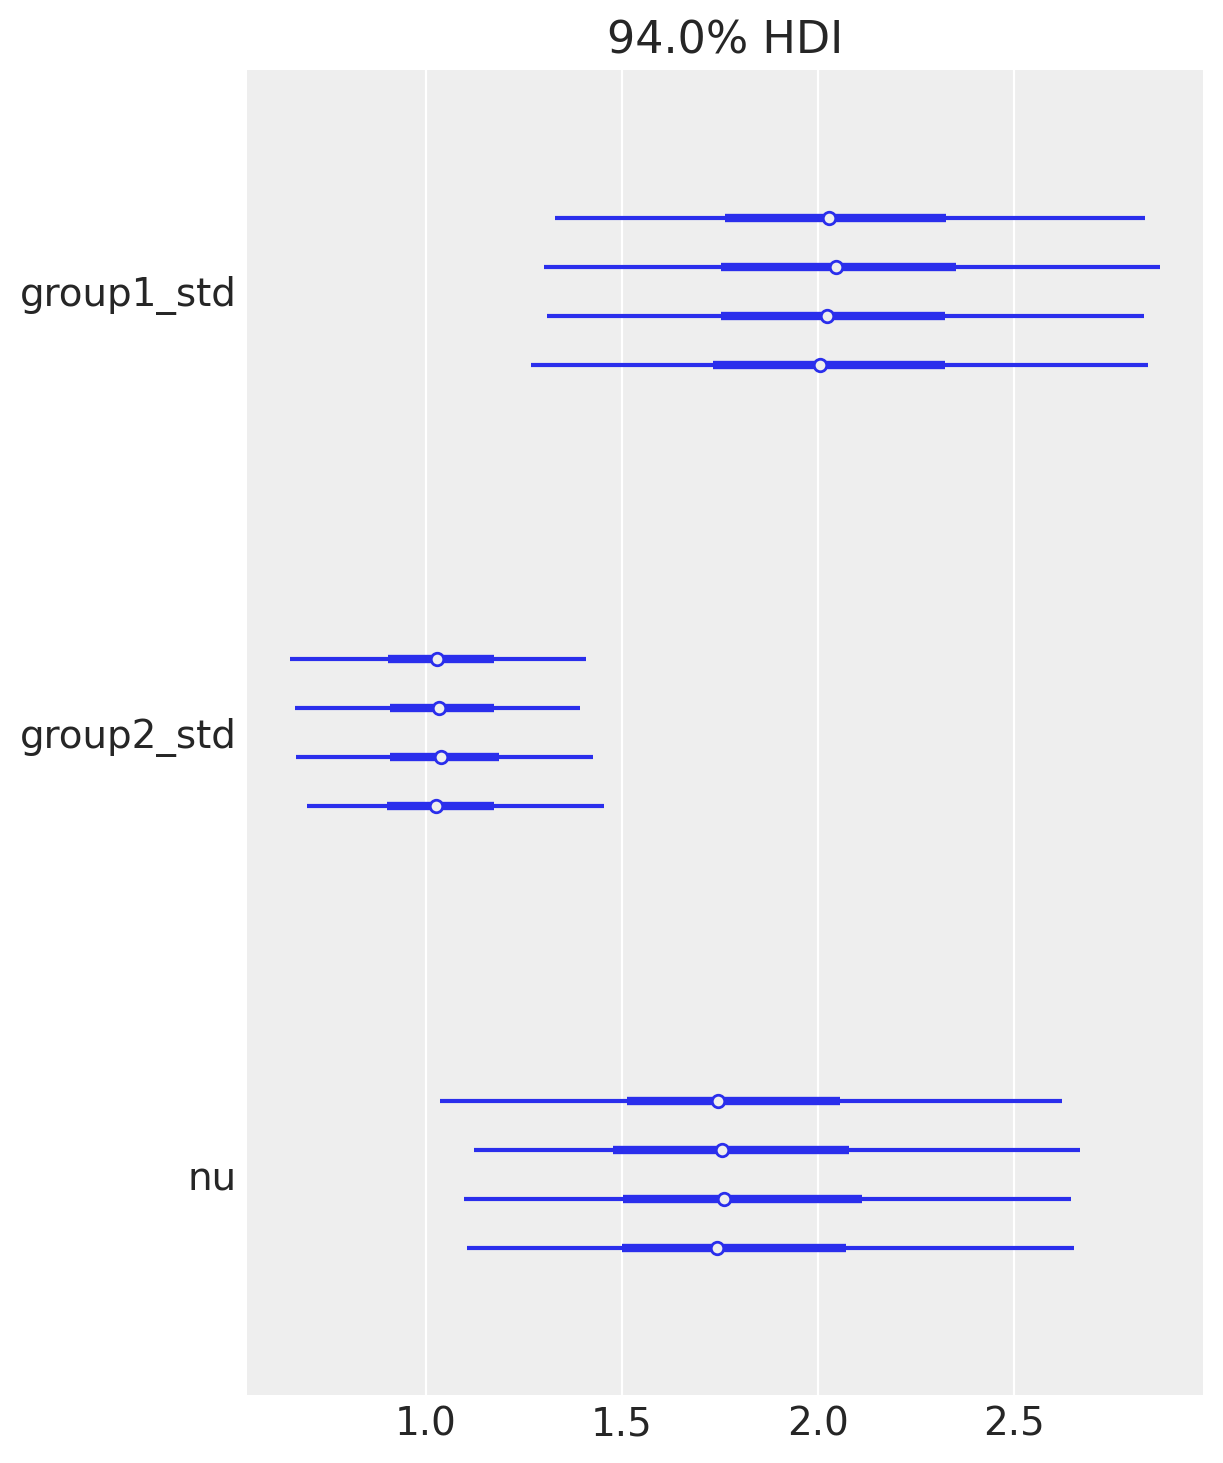

In [13]:
az.plot_forest(idata, var_names=["group1_std", "group2_std", "nu"]);

In [14]:
az.summary(idata, var_names=["difference of means", "difference of stds", "effect size"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
difference of means,1.022,0.428,0.204,1.833,0.007,0.005,3588.0,2924.0,1.0
difference of stds,1.009,0.439,0.188,1.831,0.007,0.005,3766.0,3033.0,1.0
effect size,0.642,0.290,0.079,1.173,0.005,0.003,3577.0,2881.0,1.0
